# Oxidation states
Here, we will demonstrate the main functionalities of the `oxidation_states` submodule of SMACT.

In [1]:
# Imports
import re
from itertools import combinations, product

import matplotlib.pyplot as plt
import multiprocess
import numpy as np
import pandas as pd
from pymatgen.core import Composition

import smact
from smact import Element, Species, screening
from smact.oxidation_states import Oxidation_state_probability_finder

## Getting started with the oxidation_states submodule

The main class of the `smact.oxidation_states` submodule is `Oxidation_state_probability_finder`. We will demonstrate the usage of the methods of this class below.

In [2]:
# Instantiate the oxidation state probability finder class with the default table
ox_prob_finder = Oxidation_state_probability_finder()

After instantiating the class, we can examine what species are included in the probability table through the `get_included_species` method.

In [3]:
included_species = ox_prob_finder.get_included_species()

print(
    f"The species included in the probability table for the oxidation states model are show below \n{included_species}"
)

The species included in the probability table for the oxidation states model are show below 
['F-1', 'I-1', 'O-2', 'Cl-1', 'S-2', 'Se-2', 'Br-1', 'Te-2', 'Mn5', 'Fe3', 'U6', 'Nb1', 'Cr4', 'Pr2', 'Re4', 'Cu2', 'Sr2', 'Sc1', 'Sb5', 'Eu3', 'Mn1', 'Ag2', 'Cs1', 'Al3', 'V5', 'Ta2', 'Dy3', 'Rb1', 'Ta4', 'La2', 'Rh4', 'Lu3', 'Nd2', 'Tm2', 'Y1', 'Re2', 'Th4', 'Co1', 'Mn2', 'Mn3', 'Ni4', 'Pb4', 'Sc3', 'W2', 'Ta3', 'Mo4', 'Ru2', 'Ru3', 'Ce3', 'Gd2', 'Tl3', 'Ir6', 'Zr4', 'Ga1', 'Sn4', 'Mn6', 'La3', 'Pr3', 'Ti2', 'Bi2', 'Tb1', 'Pd4', 'Ru5', 'Eu2', 'Pb2', 'Nd3', 'Ru6', 'Cr6', 'Hf4', 'Zr2', 'Ho3', 'Ce4', 'Ce2', 'Ge3', 'Th3', 'Mg2', 'Re3', 'Co4', 'Ni1', 'Ni2', 'Ir3', 'Gd3', 'In2', 'Y3', 'U4', 'Re5', 'Ir4', 'Mo2', 'Sn3', 'Cu3', 'Ti3', 'Tb2', 'Pd3', 'Bi5', 'Y2', 'U3', 'Ge4', 'Mo3', 'Zr3', 'Er3', 'Sm2', 'Sm3', 'Cr2', 'Sb3', 'Mo6', 'Be2', 'Ta5', 'V3', 'Rh1', 'Pd2', 'Dy2', 'Cd2', 'Sn2', 'Tb4', 'Co3', 'Re6', 'Yb3', 'W3', 'Mo5', 'Re7', 'Hf2', 'Fe2', 'Ag1', 'Ir5', 'Nb5', 'Yb2', 'Li1', 'Tl1', 'Zr1', 'Zn2', 'S

We can compute the probability of a cation-anion pair appearing together using the method `pair_probability` as demonstrated below for Al<sup>3+</sup> and O<sup>2-</sup>. The pair probability for a species-anion pair ($P_{SA}$) is given by:

$P_{SA} = \frac{N_{SX}}{N_{MX}}$

where $N_{MX}$ is the total number of compounds containing the metal element M, and X is the most electronegative anion.

In [4]:
Al = Species("Al", oxidation=3, coordination=6)
O = Species("O", oxidation=-2, coordination=6)

print(
    f" The probability of Al existing in 3+ oxidation states with O in a 2- oxidation state is {ox_prob_finder.pair_probability(Al,O)}"
)

 The probability of Al existing in 3+ oxidation states with O in a 2- oxidation state is 1.0


We can also compute the compound probability which for a ternary compound, A<sub>a</sub>B<sub>b</sub>X<sub>x</sub>, is given by:

$P_{A_{a}B_{b}X_{x}} = P_{AX}P_{BX} = \frac{N_{AX}}{N_{M_{A}X}} \times \frac{N_{BX}}{N_{M_{B}X}}$

We will calculate $P_{CaAl_{2}O_{4}}$.

In [5]:
# Create a list of species for our compound of interest
CaAl2O4 = [Species("Ca", 2), Species("Al", 3), Species("O", -2)]

prob_compound = ox_prob_finder.compound_probability(CaAl2O4)

print(f"The compound probability for CaAl2O4 is {prob_compound}.")

The compound probability for CaAl2O4 is 1.0.


## Filtering a SMACT search space using the oxidation states model

Let's attempt to perform the first steps in a high-throughput compound design workflow which involves:
* Generating the search space using SMACT
* Filtering the search space using the oxidation states model.

### Composition generation

In [6]:
# Get the cations that are in the probability table
cations = [
    species for species in ox_prob_finder.get_included_species() if "-" not in species
]

# Get the symbols of the d-block elements
d_block_symbols = (
    smact.ordered_elements(21, 30)
    + smact.ordered_elements(39, 48)
    + smact.ordered_elements(71, 80)
)

# This function will parse the species included in the probability table


def parse_species(species):
    match = re.match(r"([A-Za-z]+)([0-9.]+)", species)
    return match.group(1), int(match.group(2))


# Create a list of the d-block smact.Species objects from the d-block species in the table
allowed_dblock_species = [
    Species(parse_species(cation)[0], parse_species(cation)[1])
    for cation in cations
    if parse_species(cation)[0] in d_block_symbols
]

# Get all the combinations of the d_block smact.Species objects
d_block_species_combos = combinations(allowed_dblock_species, 2)

# Use this custom smact_filter function to generate the plausible compositions


def smact_filter(els):
    all_compounds = []
    halide_symbols = ["F", "Cl", "Br", "I"]

    for halide in halide_symbols:
        elements = [e.symbol for e in els] + [halide]

        halide_species = Species(halide, -1)

        # Get the Pauling electronegativities
        paul_a, paul_b, paul_x = (
            els[0].pauling_eneg,
            els[1].pauling_eneg,
            halide_species.pauling_eneg,
        )
        electronegativities = [paul_a, paul_b, paul_x]

        # For each set of species (in oxidation states) apply both SMACT tests
        ox_a, ox_b = els[0].oxidation, els[1].oxidation
        ox_states = [ox_a, ox_b, -1]
        # Test for charge balance
        cn_e, cn_r = smact.neutral_ratios(ox_states, threshold=8)
        if cn_e:
            # Electronegativity test
            electroneg_OK = screening.pauling_test(ox_states, electronegativities)
            if electroneg_OK:
                compound = tuple(
                    [elements, (ox_a, ox_b, -1), cn_r[0], list(els) + [halide_species]]
                )
                all_compounds.append(compound)
    return all_compounds

In [7]:
# Use multiprocess to speed up the generation of the combinations
with multiprocess.Pool(3) as p:
    result = p.map(smact_filter, d_block_species_combos)

flat_list = [item for sublist in result for item in sublist]

# Here we grab the species string for each composition generated by smact
list_of_species = [species[3] for species in flat_list]
A_species = [
    f"{species[0].symbol}{species[0].oxidation}+" for species in list_of_species
]
B_species = [
    f"{species[1].symbol}{species[1].oxidation}+" for species in list_of_species
]
X_species = [f"{species[2].symbol}1-" for species in list_of_species]

# Print out the first few entries from our search space
print(f"Number of compositions: {len(flat_list)}")
print("Each list entry looks like this:\n  elements, oxidation states, stoichiometries")
for i in flat_list[:5]:
    print(i[0], i[1], i[2])

Number of compositions: 14832
Each list entry looks like this:
  elements, oxidation states, stoichiometries
['Mn', 'Fe', 'F'] (5, 3, -1) (1, 1, 8)
['Mn', 'Fe', 'Cl'] (5, 3, -1) (1, 1, 8)
['Mn', 'Fe', 'Br'] (5, 3, -1) (1, 1, 8)
['Mn', 'Fe', 'I'] (5, 3, -1) (1, 1, 8)
['Mn', 'Nb', 'F'] (5, 1, -1) (1, 1, 6)


In [8]:
# Get the formulas for the compositions


def comp_maker(comp):
    form = []
    for el, ammt in zip(comp[0], comp[2]):
        form.append(el)
        form.append(ammt)
    form = "".join(str(e) for e in form)
    pmg_form = Composition(form).reduced_formula
    return pmg_form


if __name__ == "__main__":
    with multiprocess.Pool(3) as p:
        pretty_formulas = p.map(comp_maker, flat_list)

print("Each list entry now looks like this: ")
for i in pretty_formulas[:5]:
    print(i)

Each list entry now looks like this: 
MnFeF8
MnFeCl8
MnFeBr8
MnFeI8
MnNbF6


### Applying the oxidation states model
The method `compound_probability` of the `Oxidation_state_probability_finder` class enables us to compute the likelihood of the metal species existing in the presence of particular anions. We will apply this to all the compounds generated by `smact`

In [9]:
# Compute the compound probabilities
compound_probabilities = [
    ox_prob_finder.compound_probability(spec) for spec in list_of_species
]

In [10]:
# Create a dataframe
data = {
    "formula_pretty": pretty_formulas,
    "A": A_species,
    "B": B_species,
    "X": X_species,
    "compound_probability": compound_probabilities,
}

df = pd.DataFrame(data)
df.head()

,formula_pretty,A,B,X,compound_probability
0,MnFeF8,Mn5+,Fe3+,F1-,0.383333
1,MnFeCl8,Mn5+,Fe3+,Cl1-,0.281250
2,MnFeBr8,Mn5+,Fe3+,Br1-,0.277778
3,MnFeI8,Mn5+,Fe3+,I1-,0.100000
4,MnNbF6,Mn5+,Nb1+,F1-,0.000000


In [11]:
# Compute the number of non-zero compound probabilities

# Convert the probability values from a pandas.Series object to a numpy array
probs = df.compound_probability.to_numpy()

# Create a numpy array of the non-zero probabilities
non_Zero_probs = probs[(probs > 0)]

print(
    f"The original smact search space produced {len(probs)} compositons of which {len(non_Zero_probs)} had a non-zero compound probability"
)

The original smact search space produced 14832 compositons of which 12671 had a non-zero compound probability


#### Visualising the compound probabilities of the SMACT generated compositions.
We will now plot the number of compounds as a function of the probability threshold.

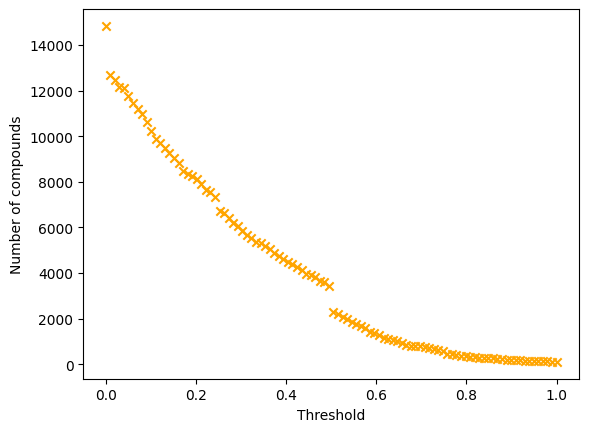

In [12]:
# Create a numpy array of 100 threshold values
thresh = np.linspace(0.0, 1.0, 100)

# Use a list comprehension to generate a list of the number of compounds as a function of the probability threshold
num_compounds = [len(probs[(probs >= t)]) for t in thresh]

# Set up the figure and plot the number of compounds against the threshold
fig, ax = plt.subplots()

ax.scatter(x=thresh, y=num_compounds, marker="x", color="orange")
plt.xlabel("Threshold")
plt.ylabel("Number of compounds")

plt.show()